In [ ]:
!pip install tensorflow-datasets keras

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import urllib3
from tqdm import tqdm
import cv2
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics.pairwise import cosine_similarity

# Helper Functions

In [ ]:
def short_euclidean_distance(mat, vec):
  # similarity
  dist = (mat - vec)**2
  dist = np.sum(dist, axis=1)
  dist = np.sqrt(dist)
  return np.argmin(dist)

def cosin_sim(mat, vec):
  from sklearn.metrics.pairwise import cosine_similarity
  sitas = cosine_similarity(mat, vec)
  return np.argmax(sitas)


def visulize(tp):
    _, axarr = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

    sample_keys = list(train_dataset.data.keys())

    for a in range(5):
      for b in range(5):
            if b == 2:
                axarr[a, b].set_title("Class : " + str(a))
            im = tp[(a*shots):(a*shots)+5][b]
            if im.shape[-1] == 1:
                axarr[a, b].imshow(im[:,:,-1])
            else:
                axarr[a, b].imshow(im)

            axarr[a, b].xaxis.set_visible(False)
            axarr[a, b].yaxis.set_visible(False)

    _.show()

def show_img(img):
    if img.shape[-1] == 1:
        plt.imshow(img[:,:,-1])
    else:
        plt.imshow(img)
    
    plt.show()

# Global Parameters

In [ ]:
width = height = 224
shots = 5
classes = 5
tasks_number = 50

# Benchmark using Omniglot dataset

# Prepare Omniglot Dataset for meta-testing

In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            global width, height
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [width, height])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())


    def get_sample_tasks(self, tasks_numbers, shots, num_classes):
        global width, height
        temp_labels = np.zeros(shape=(tasks_numbers, num_classes))
        temp_images = np.zeros(shape=(tasks_numbers, num_classes * shots, width, height, 1))
        test_sample = np.zeros(shape=(tasks_numbers, width, height, 1))
        test_sample_lable = np.zeros(shape=(tasks_numbers))

        for tn in range(tasks_numbers):
            # Get a random subset of labels from the entire label set.
            label_subset = np.random.choice(self.labels, num_classes, replace=False)

            for class_idx, class_obj in enumerate(label_subset):
                # Use enumerated index value as a temporary label for mini-batch in
                # few shot learning.
                temp_labels[tn, class_idx] = class_idx

                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                # temp_images[tn, class_idx] = 
                rand_indexs = np.random.choice(range(len(self.data[label_subset[class_idx]])), shots, replace=False)
                temp_images[tn, class_idx * shots : (class_idx + 1) * shots] = np.array(self.data[label_subset[class_idx]])[rand_indexs]

            test_num = random.choice(range(0,classes))
            test_sample[tn] = random.choice(self.data[label_subset[test_num]])
            test_sample_lable[tn] = test_num

        return temp_labels, temp_images, test_sample, test_sample_lable
        

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=False)

# Create N Tasks Sample from Omniglot

In [ ]:
temp_labels, temp_images, test_sample, test_sample_lable = train_dataset.get_sample_tasks(tasks_number, shots, classes)
temp_labels.shape , temp_images.shape, test_sample.shape, test_sample_lable.shape

((50, 5), (50, 25, 224, 224, 1), (50, 224, 224, 1), (50,))

In [ ]:
temp_images[0].shape

(25, 224, 224, 1)

# Compile EfficientNetB0

In [ ]:
model = EfficientNetB0(include_top=False, weights='imagenet')
model.build([None, width, height, 1])  # Batch input shape.

16719872/16705208 [==============================] - 0s 0us/step


# Test the accuracy of N tasks grabbed from Omniglot dataset

In [ ]:
accurcy_ec = []
accurcy_cos = []

for tn in tqdm(range(tasks_number)):
    # embedding the support-set 
    test_preds = model(temp_images[tn])
    test_preds = tf.keras.layers.GlobalAveragePooling2D()(test_preds)

    test_pred_matrix = np.array(np.array(test_preds).reshape(classes, -1, test_preds.shape[-1]))
    test_pred_sum_shots = np.mean(test_pred_matrix, axis=1)

    # read query image and get its embedding
    query_matrix = test_sample[tn]
    query_embedding = model(np.expand_dims(query_matrix, axis=0))
    query_embedding = tf.keras.layers.GlobalAveragePooling2D()(query_embedding)

    accurcy_ec.append(short_euclidean_distance(test_pred_sum_shots, query_embedding) == test_sample_lable[tn])
    accurcy_cos.append(cosin_sim(test_pred_sum_shots, query_embedding) == test_sample_lable[tn])

100%|██████████| 50/50 [02:15<00:00,  2.72s/it]


In [ ]:
print(f"EC acc :: {sum(accurcy_ec)/len(accurcy_ec)}%")
print(f"COS acc :: {sum(accurcy_cos)/len(accurcy_cos)}%")

EC acc :: 0.48%
COS acc :: 0.52%


# Visualize one task of Omniglot dataset

In [ ]:
test_task = 1

test_preds = model(temp_images[test_task])
test_preds = tf.keras.layers.GlobalAveragePooling2D()(test_preds)

test_pred_matrix = np.array(np.array(test_preds).reshape(classes, -1, test_preds.shape[-1]))
print(test_pred_matrix.shape)

test_pred_sum_shots = np.mean(test_pred_matrix, axis=1)
#test_pred_sum_shots = np.linalg.norm(test_pred_matrix, axis=1)
print(test_pred_sum_shots.shape)

# read query image and get its embedding
query_matrix = test_sample[test_task]
query_embedding = model(np.expand_dims(query_matrix, axis=0))
query_embedding = tf.keras.layers.GlobalAveragePooling2D()(query_embedding)
print(query_embedding.shape)

print(f"True Class :: {test_sample_lable[test_task]}")
print(f"Predicted class based on euclidean_distance :: {short_euclidean_distance(test_pred_sum_shots, query_embedding)}")
print(f"Predicted class based on cosin_sim :: {cosin_sim(test_pred_sum_shots, query_embedding)}")

(5, 5, 1280)
(5, 1280)
(1, 1280)
True Class :: 0.0
Predicted class based on euclidean_distance :: 0
Predicted class based on cosin_sim :: 0


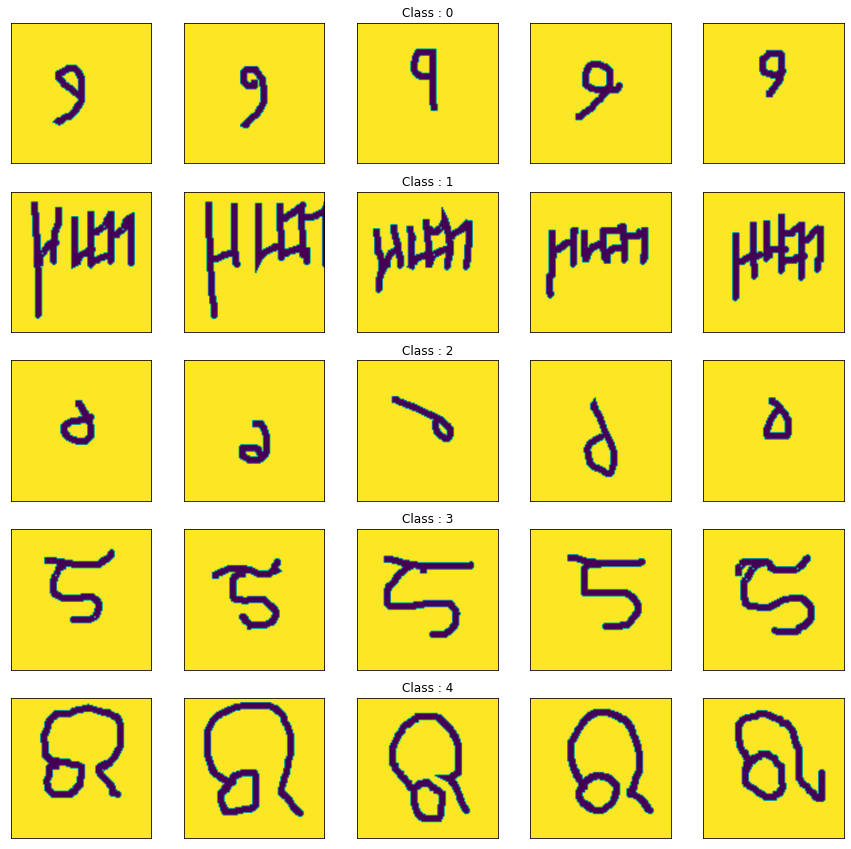

In [ ]:
visulize(temp_images[test_task])

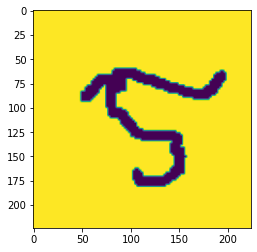

In [ ]:
show_img(test_sample[test_task])

# Benchmark using CIFAR-10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

# Prepare CIFAR-10 Dataset for meta-testing

In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            global width, height
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            #image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [width, height])
            return image, label[0]

        for i in range(5000):
            image, label = extraction(x_test[i], y_test[i])
            image = image.numpy()
            label = str(label)
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())


    def get_sample_tasks(self, tasks_numbers, shots, num_classes):
        global width, height
        temp_labels = np.zeros(shape=(tasks_numbers, num_classes))
        temp_images = np.zeros(shape=(tasks_numbers, num_classes * shots, width, height, 3))
        test_sample = np.zeros(shape=(tasks_numbers, width, height, 3))
        test_sample_lable = np.zeros(shape=(tasks_numbers))

        for tn in range(tasks_numbers):
            # Get a random subset of labels from the entire label set.
            label_subset = np.random.choice(self.labels, num_classes, replace=False)

            for class_idx, class_obj in enumerate(label_subset):
                # Use enumerated index value as a temporary label for mini-batch in
                # few shot learning.
                temp_labels[tn, class_idx] = class_idx

                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                # temp_images[tn, class_idx] = 
                
                rand_indexs = np.random.choice(range(len(self.data[label_subset[class_idx]])), shots, replace=False)
                temp_images[tn, class_idx * shots : (class_idx + 1) * shots] = np.array(self.data[label_subset[class_idx]])[rand_indexs]

            test_num = random.choice(range(0, num_classes))
            test_sample[tn] = random.choice(self.data[label_subset[test_num]])
            test_sample_lable[tn] = test_num

        return temp_labels, temp_images, test_sample, test_sample_lable
        

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)

# Create N Tasks Sample from CIFAR-10

In [ ]:
temp_labels, temp_images, test_sample, test_sample_lable = train_dataset.get_sample_tasks(tasks_number, shots, classes)
temp_labels.shape , temp_images.shape, test_sample.shape, test_sample_lable.shape

((50, 5), (50, 25, 224, 224, 3), (50, 224, 224, 3), (50,))

In [ ]:
temp_images[0].shape

(25, 224, 224, 3)

# Compile EfficientNetB0

In [ ]:
model = EfficientNetB0(include_top=False, weights='imagenet')
model.build([None, width, height, 3])  # Batch input shape.

# Test the accuracy of N tasks grabbed from CIFAR-10 dataset

In [ ]:
accurcy_ec = []
accurcy_cos = []

for tn in tqdm(range(tasks_number)):
    test_preds = model(temp_images[tn])
    test_preds = tf.keras.layers.GlobalAveragePooling2D()(test_preds)

    test_pred_matrix = np.array(np.array(test_preds).reshape(classes, -1, test_preds.shape[-1]))
    test_pred_sum_shots = np.mean(test_pred_matrix, axis=1)

    # read query image and get its embedding
    query_matrix = test_sample[tn]
    query_embedding = model(np.expand_dims(query_matrix, axis=0))
    query_embedding = tf.keras.layers.GlobalAveragePooling2D()(query_embedding)

    accurcy_ec.append(short_euclidean_distance(test_pred_sum_shots, query_embedding) == test_sample_lable[tn])
    accurcy_cos.append(cosin_sim(test_pred_sum_shots, query_embedding) == test_sample_lable[tn])

100%|██████████| 50/50 [01:32<00:00,  1.84s/it]


In [ ]:
print(f"EC acc :: {sum(accurcy_ec)/len(accurcy_ec)}%")
print(f"COS acc :: {sum(accurcy_cos)/len(accurcy_cos)}%")

EC acc :: 0.34%
COS acc :: 0.34%


# Visualize one task of CIFAR-10 dataset

In [ ]:
test_task = 0

test_preds = model(temp_images[test_task])
test_preds = tf.keras.layers.GlobalAveragePooling2D()(test_preds)

test_pred_matrix = np.array(np.array(test_preds).reshape(classes, -1, test_preds.shape[-1]))
print(test_pred_matrix.shape)
# test_pred_matrix = np.array([test_preds[(i*classes):(i*classes)+classes] for i in range(classes)])
test_pred_sum_shots = np.sum(test_pred_matrix, axis=1)
print(test_pred_sum_shots.shape)

# read query image and get its embedding
query_matrix = test_sample[test_task]
query_embedding = model(np.expand_dims(query_matrix, axis=0))
query_embedding = tf.keras.layers.GlobalAveragePooling2D()(query_embedding)
print(query_embedding.shape)


print(f"True Class :: {test_sample_lable[test_task]}")
print(f"Predicted class based on euclidean_distance :: {short_euclidean_distance(test_pred_sum_shots, query_embedding)}")
print(f"Predicted class based on cosin_sim :: {cosin_sim(test_pred_sum_shots, query_embedding)}")

(5, 5, 1280)
(5, 1280)
(1, 1280)
True Class :: 2.0
Predicted class based on euclidean_distance :: 2
Predicted class based on cosin_sim :: 0


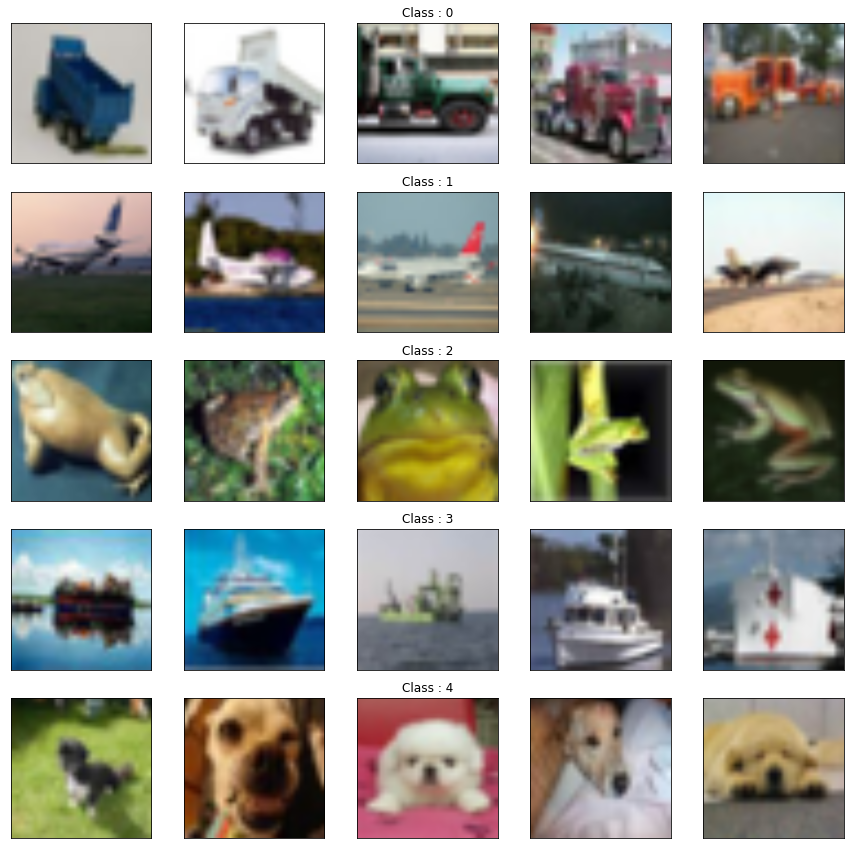

In [ ]:
visulize(temp_images[test_task])

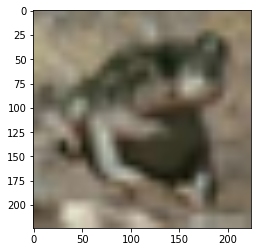

In [ ]:
show_img(test_sample[test_task])

# Thanks IBM